# 1. Import Library & Load Data

In [60]:
import sys
import os
import pandas as pd
import numpy as np
import sqlite3 as db
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [61]:
# Connect to a dfbase
#data cleaning
file_path = 'data\score.db'

if os.path.isfile(file_path):
    print('File exists')
else:
    print('File does not exist')

conn = db.connect(file_path)

df = pd.read_sql_query("SELECT * from score", conn)
conn.close()
df.head()


File exists


,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


# 2. Preprocessing & EDA

## Filtering to Secondary School age only

The data also includes students that are not of O-level age. \
We shall filter the data to include only students of age 15 and 16. 

age
 15.0    7726
 16.0    7723
 6.0      230
 5.0      216
-5.0        4
-4.0        1
Name: count, dtype: int64


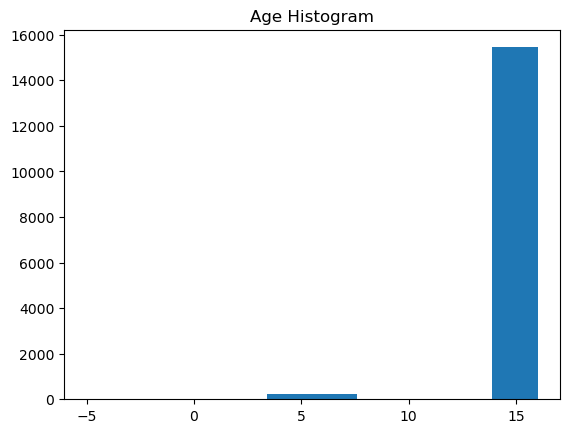

In [62]:
# plot age histogram
plt.hist(df['age'])
plt.title('Age Histogram')
print(df['age'].value_counts())

df = df[df['age'] >= 15]

## Data Summary and Missing values

There are a total of 15,449 datapoints, with 15 variables.

We see that there are null values in 'final_test' and 'attendance_rate' which we will address later.

In [63]:
print("Data Types and Missing Values:\n")
df.drop(['student_id','index'], axis=1, inplace=True)
print(df.info())

Data Types and Missing Values:

<class 'pandas.core.frame.DataFrame'>
Index: 15449 entries, 0 to 15899
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_siblings  15449 non-null  int64  
 1   direct_admission    15449 non-null  object 
 2   CCA                 15449 non-null  object 
 3   learning_style      15449 non-null  object 
 4   gender              15449 non-null  object 
 5   tuition             15449 non-null  object 
 6   final_test          14969 non-null  float64
 7   n_male              15449 non-null  float64
 8   n_female            15449 non-null  float64
 9   age                 15449 non-null  float64
 10  hours_per_week      15449 non-null  float64
 11  attendance_rate     14690 non-null  float64
 12  sleep_time          15449 non-null  object 
 13  wake_time           15449 non-null  object 
 14  mode_of_transport   15449 non-null  object 
 15  bag_color           15449 

## CCA & Tuition Data Cleaning

Below, we see the unique values of categorical variables in the dataset. \
Notice that some data cleaning is required for 'CCA' & 'tuition'. 

In [64]:
categorical_columns = ['direct_admission', 'CCA', 'learning_style', 'gender', 'mode_of_transport', 'bag_color', 'tuition', 'age']

for col in categorical_columns:
    print('Value Counts for Column:', col)
    print(df[col].value_counts())
    print('\n')

Value Counts for Column: direct_admission
direct_admission
No     10873
Yes     4576
Name: count, dtype: int64


Value Counts for Column: CCA
CCA
Clubs     3804
Sports    3759
None      3722
Arts      3672
CLUBS      141
NONE       125
ARTS       121
SPORTS     105
Name: count, dtype: int64


Value Counts for Column: learning_style
learning_style
Auditory    8891
Visual      6558
Name: count, dtype: int64


Value Counts for Column: gender
gender
Male      7761
Female    7688
Name: count, dtype: int64


Value Counts for Column: mode_of_transport
mode_of_transport
public transport     6190
private transport    6144
walk                 3115
Name: count, dtype: int64


Value Counts for Column: bag_color
bag_color
yellow    2656
black     2589
green     2582
blue      2548
red       2538
white     2536
Name: count, dtype: int64


Value Counts for Column: tuition
tuition
Yes    8440
No     6447
Y       315
N       247
Name: count, dtype: int64


Value Counts for Column: age
age
15.0    7726

In [65]:
df['CCA'].str.lower().str.title() 

0        Sports
1        Sports
2          None
3         Clubs
4        Sports
          ...  
15895     Clubs
15896      None
15897    Sports
15898     Clubs
15899      None
Name: CCA, Length: 15449, dtype: object

In [ ]:
df['CCA'] = df['CCA'].str.lower().str.title() 
df.loc[df['CCA'] == 'None', 'CCA'] = 'None'
df.loc[df['CCA'] == 'N/A', 'CCA'] = 'None'
df.loc[df['CCA'] == 'Arts', 'CCA'] = 'Arts'
df.loc[df['CCA'] == 'Sports', 'CCA'] = 'Sports'
df.loc[df['CCA'] == 'Clubs', 'CCA'] = 'Clubs'
df['tuition'] = df['tuition'].replace({'Y': 'Yes', 'N': 'No'})

for col in categorical_columns:
    print('Value Counts for Column:', col)
    print(df[col].value_counts())
    print('\n')

## Feature Engineering (hours_of_sleep)

Here we see there is 'sleep_time' and 'wake_time.'\
Let's change it to 'hours_of_sleep' and drop the above. \
We see that majority of students have 8 hours of sleep.

In [ ]:
df['hours_of_sleep'] = (pd.to_datetime(df['wake_time']) - pd.to_datetime(df['sleep_time'])).dt.seconds / 3600
df.drop(['sleep_time', 'wake_time'], axis=1, inplace=True)


In [ ]:
plt.hist(df['hours_of_sleep'], bins=10)
plt.xlabel('hours_of_sleep')
plt.ylabel('Count')
plt.title('Histogram of hours_of_sleep')
plt.show()

## Pairplots

Pairplot creation to check for patterns of initial data. 


In [ ]:
numerical_cols = ['final_test', 'n_male', 'n_female', 'hours_per_week', 'attendance_rate', 'hours_of_sleep', 'number_of_siblings']

sns.pairplot(df[numerical_cols], kind='reg', plot_kws={'line_kws':{'color':'red'}})

## attendance & final grade
There seems to be a wierd pattern between attendance and final_test. \
It definitely looks like there is a cap to final_test given a certain range of attendance. \
We can make the following observations: 
- Between 40-50% attendance, final test scores seems to be capped at 45.
- Between 50-90% attendance, final test scores seems to be capped at 50. 
- Between 90-10% attendance, full final test scores can be achieved. 

Students seems to be able to be grouped into 3 types in 'attendance_rate'.



In [ ]:
plt.scatter(df['attendance_rate'], df['final_test'])
plt.xlabel('Attendance Rate')
plt.ylabel('Final Test Score')
plt.title('Attendance Rate vs Final Test Score')
plt.figure(figsize=(10,6))
plt.show()

## Feature Engineering (att_type)

We create a new variable called att_type: 
- If attendance rate < 50, then attendance type is C
- If attendance rate < 90 then attendance type is B
- If attendance rate 90-100, then attendance type is A

We include both as we see that attendance_rate sets distinct limits in terms of student final test scores. 
The categorical variable 'att_type' would capture broad attendance categories while 'attendance_rate' would provide finer information of the student's attendance rate. 

In [ ]:
def classify_attendance_type(att_rate):
    if att_rate < 50:
        return 'C'
    elif att_rate < 90:
        return 'B'
    elif np.isnan(att_rate):
        return np.nan
    else:
        return 'A'
    
df['att_type'] = df['attendance_rate'].apply(classify_attendance_type)

categorical_columns.append('att_type')

In [ ]:

colors = {'C': 'red', 'B': 'blue', 'A': 'green', np.nan: 'black'} 
plt.scatter(df['attendance_rate'], df['final_test'], c=df['att_type'].map(colors))
plt.xlabel('Attendance Rate')
plt.ylabel('Final Test Score')
handles = [plt.Line2D([0], [0], marker='o', color='w', label=att_type, markersize=10, markerfacecolor=colors[att_type]) for att_type in colors]
plt.legend(handles=handles, title="Attendance Type")
plt.title('Attendance Rate vs Final Test Score')
plt.figure(figsize=(10,6))

plt.show()

## Handling Missing Values and Imputing Attendance_rate

Previously, we have checked that 'final_test' and 'attendance_rate' contains missing values. \
Here we shall do data cleaning for these variables. \
We can assume the 'att_type' based on the student's final_test score, and then impute the 'attendance_rate' based on the mean value of students in the same 'att_type'. \
For students that are missing 'final_test' data, we shall drop them. 

This includes the following steps:
1. Drop rows if final_test is Nan. 
2. Calculate the mean test score grouped by 'att_type.'
3. Assign the 'att_type' based on 'final_test' and impute 'attendance_rate' :
    - If final_test > 50, then att_type = A, attendance_rate mean of A
    - If final_test > 45, then att_type = B, attendance_rate mean B
    - else final_test < 45, then att_type = C, attendance_rate mean C

In [ ]:
# 1. drop rows if final_score is NAN (since hard to impute)
df = df.dropna(subset=['final_test'])
#Get the mean of each att_type
mean_attendance = df.groupby('att_type')['attendance_rate'].mean()
list_att_mean = list(mean_attendance)
# 2. If final_test > 50, then att_type = A, attendance_rate mean 1
# 3. If final_test > 45, then att_type = B, attendance_rate mean 2
# 4. else final_test < 45, then att_type = C, attendance_rate mean 3
mask_A = (df['att_type'].isna()) & (df['final_test'] > 50)
mask_B = (df['att_type'].isna()) & (df['final_test'] > 45) & (df['final_test'] <= 50)
mask_C = (df['att_type'].isna()) & (df['final_test'] <= 45)

df.loc[mask_A, 'att_type'] = 'A'
df.loc[mask_A, 'attendance_rate'] = list_att_mean[0]

df.loc[mask_B, 'att_type'] = 'B'
df.loc[mask_B, 'attendance_rate'] = list_att_mean[1]

df.loc[mask_C, 'att_type'] = 'C'
df.loc[mask_C, 'attendance_rate'] = list_att_mean[2]
# check nans
print('Number of NaNs in the dataset: ', df.isnull().sum().sum())


## hours per week & final grade (and attendance type)
We also see an interesting pattern between hours per week, attendance type and final grade. \
We can make the following observation: 
 - when hours_per_week is below 5, final test scores cannot be above 75 and there is a gap between 51 - 75. Only those with Attendance type A (>90) are able to score around 75.
 - when hours per week is 5 to 10, full final test scores can be achieved. 
 - when hours per week is above 10 and below 15.0, final test scores are capped at 75.
 - when hours per week is above 15.0, final test scores are at least 50 but below 75. 



In [ ]:
plt.scatter(df['hours_per_week'], df['final_test'], c= df['att_type'].map(colors))
plt.xlabel('hours_per_week')
plt.ylabel('Final Test Score')
plt.title('hours_per_week vs Final Test Score')
handles = [plt.Line2D([0], [0], marker='o', color='w', label=att_type, markersize=10, markerfacecolor=colors[att_type]) for att_type in colors]
plt.legend(handles=handles, title="Attendance Type")
plt.figure(figsize=(10,6))
plt.show()

## number_of_siblings

The relationship between 'number_of_siblings' and 'final_test' do not appear linear:
- Students with 0 siblings have the highest mean and median at approximately 76.
- Students with 2 siblings have higher mean and median compared to students with 1 siblings.

Therefore, number of siblings should be categorized as a categorical variable.


In [ ]:
order = sorted(df['number_of_siblings'].unique())
ax = sns.violinplot(x='number_of_siblings', y='final_test', data=df, order=order, inner=None, color='lightgray')

for i, category in enumerate(order):
    category_data = df[df['number_of_siblings'] == category]['final_test']
    
    # Median
    median = category_data.median()
    ax.plot([i-0.2, i+0.2], [median, median], color='red', lw=1, label='median' if i==0 else "")
    ax.text(i, median, f'{median:.2f}', ha='right', va='bottom', color='red', fontsize=10)
    
    # Mean
    mean = category_data.mean()
    ax.plot([i-0.3, i+0.3], [mean, mean], color='blue', linestyle='--', lw=1, label='mean' if i==0 else "")
    ax.text(i, mean, f'{mean:.2f}', ha='left', va='top', color='blue', fontsize=10)

# Adding legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='upper right')  # show one legend entry for median and mean
plt.show()


In [ ]:

ax = sns.boxplot(x='number_of_siblings', y='final_test', data=df, order=order, showmeans=True, meanline=True,
                 meanprops={"marker":"o",
                            "markerfacecolor":"blue", 
                            "markeredgecolor":"black",
                            "markersize":"8"})

for i, category in enumerate(order):
    category_data = df[df['number_of_siblings'] == category]['final_test']
    
    # Median
    median = category_data.median()
    ax.scatter(i, median, color='red', s=50, label='Median' if i==0 else "", zorder=10)
    ax.text(i, median, f'{median:.2f}', ha='right', va='bottom', color='red', fontsize=10, zorder=10)
    
    # Mean
    mean = category_data.mean()
    ax.text(i, mean, f'{mean:.2f}', ha='left', va='top', color='blue', fontsize=10, zorder=10)

# Adding legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Median')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Mean')
ax.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.show()


In [ ]:
categorical_columns.append('number_of_siblings')
numerical_cols.remove('number_of_siblings')

##  Feature Engineering 'class_size', 'school_type'

Empirically, 'class_size' is an important predictor for test scores. We can create it by summing 'n_male' and 'n_female'.

We should also compare if gendered schools and mixed schools have a difference in test scores. We can engineer this from 'n_male' and 'n_female'.

In [ ]:
# 'class_size'
df['class_size'] = df['n_male'] + df['n_female']

# 'school_type'
conditions = [
    (df['n_male'] > 0) & (df['n_female'] == 0),
    (df['n_female'] > 0) & (df['n_male'] == 0),
    (df['n_male'] > 0) & (df['n_female'] > 0)
]
choices = ['boy_sch', 'girl_sch', 'mixed']
df['school_type'] = np.select(conditions, choices, default='unknown')

df.drop(['n_male','n_female'], axis=1, inplace=True)

numerical_cols.append('class_size')
numerical_cols.remove('n_male')
numerical_cols.remove('n_female')

categorical_columns.append('school_type')



## KDE & Histogram plot for Numerical Columns

We notice the following:
- 'attendance_rate' and 'hours_of_sleep' shows negative skewness. Most students tend to have a attendance of between 90 - 100 and 8 hours of sleep.
- 'final_test' distribution shows that a multimodal distribution. ('attendance_rate' mentioned previously sets a limit in grades.)
- 'class_size' distribution and also 'hours_per_week' also shows a multimodal distribution. 


In [ ]:
from scipy.stats import gaussian_kde

bins_m = int(np.sqrt(len(df))) #square root rule

fig, ax = plt.subplots(3, 2, figsize=(15, 20))
for i, col in enumerate(numerical_cols):
    row = i // 2 
    col_idx = i % 2
    ax[row, col_idx].hist(df[col], bins=bins_m, density=True, color='skyblue')
    kde = gaussian_kde(df[col], bw_method='silverman')
    bw = kde.factor
    x = np.linspace(df[col].min(), df[col].max(), 100)
    ax[row, col_idx].plot(x, kde(x), color='red', label='KDE')
    ax[row, col_idx].legend(['KDE', 'Histogram'])
    ax[row, col_idx].set_title(col)
    ax[row, col_idx].set_xlabel(col)
    ax[row, col_idx].set_ylabel('Density')
plt.suptitle('Distribution of Numerical Variables', fontsize=20)
plt.tight_layout()
plt.show()


# Categorical Plot
We make some observations:
- Majority of students do direct admission to schools. 
- There are relatively even distribution of students for categories CCA, bag colour, gender. 
- Slightly more students are auditory learners.
- Students have preferences for private and public transport than walking. 
- Slightly more students have access to tuition. 
- Most schools are mixed schools (91.4%).
- Majority of students have 1-2 siblings. 


In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(15, 30))
for idx, cat_var in enumerate(categorical_columns):
    row = idx // 2
    col = idx % 2
    sns.countplot(data=df, x=cat_var, ax=axs[row][col])
    # label percentage
    for p in axs[row][col].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(df))
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() + 5
        axs[row][col].annotate(percentage, (x, y))

## Categorical Variables Distribution by Attendance Type ('att_type')

A notable observation here is that 'att_type' is correlated to 'hours_of_sleep'. \
Students who do not have at least 7 hours of sleep is likely to have lower attendance. 

In [ ]:
stacked_columns = categorical_columns.copy()
stacked_columns.remove('att_type')
stacked_columns.append('hours_of_sleep')


fig, axs = plt.subplots(6, 2, figsize=(20, 40))

for idx, cat_var in enumerate(stacked_columns):
    row = idx // 2
    col = idx % 2
    ax = axs[row][col]
    
    sns.countplot(data=df, x=cat_var, hue='att_type', ax=ax, palette=['green', 'blue', 'red'])

    ax.set_title(cat_var)
    ax.set_ylabel('Count')
    ax.set_xlabel('')

    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
    
    if cat_var != 'direct_admission':
        ax.legend().set_visible(False)
    else:
        ax.legend(title='Attendance Type', loc='upper right')
plt.suptitle('Distribution of Categorical Variables by Attendance Type', fontsize=15)
plt.show()

In [ ]:
sleep_att_df = df[['hours_of_sleep', 'att_type']]

crosstab_df = pd.crosstab(sleep_att_df['hours_of_sleep'], sleep_att_df['att_type'], normalize=False)

def calculate_percentage(row):
    return row / row.sum()

print(crosstab_df)
print("",sep="\n")

percentage_df = crosstab_df.apply(calculate_percentage, axis=1)

percentage_df = percentage_df.round(2)

print(percentage_df)

# 3. Statistical Tests

After dummy code encoding, below are reference categories:
- direct_admission_No
- CCA_Arts
- learning_style_Auditory
- gender_Female
- mode_of_transport_private_transport
- bag_color_black
- age_15.0
- tuition_No
- att_type_A
- number_of_siblings_0
- school_type_boy_sch



Interpretation at 5% significance levels:
- CCA, mode_of_transport, bag_color are significant as some categories show significant differences from reference categories.
- However not all of these categories within these variables are significant (e.g. Clubs for CCA, walk for mode_of_transport, blue and green for bag_color)
- other variables shows strong significance.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

df_stat = df.copy()

encoder = OneHotEncoder(drop='first')
encoded_features = encoder.fit_transform(df_stat[categorical_columns]).toarray()
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Reset the index of both dataframes before concatenating
df_stat.reset_index(drop=True, inplace=True)
encoded_data.reset_index(drop=True, inplace=True)

df_stat = pd.concat([df_stat, encoded_data], axis=1)
df_stat.drop(categorical_columns, axis=1, inplace=True)

print("After one-hot encoding:", df_stat.isnull().sum().sum())

X = df_stat.drop('final_test', axis=1)
y = df_stat['final_test']



In [ ]:
model = sm.OLS(y,X,missing='drop').fit()
p_values = model.pvalues

# Significant 
print(p_values[p_values < 0.05].sort_values(ascending=True))

In [ ]:
# Not Significant
print(p_values[p_values > 0.05])

## Residual Plot

Residual vs Fitted Plot Graph shows non-linearity as residuals are not randomly dispersed.\
Relationship between predictors and the response variables might not be linear.

However, residuals are normally distributed based on histogram plot and Q-Q plot. 



In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = model.resid

# predicted values
fitted = model.fittedvalues

# residual plot
plt.scatter(fitted, residuals, alpha=0.5)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Plot')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


# histogram
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.5)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()


## Correlation Matrix Heatmap

We observe the following: 

- 'attendance_rate' and 'hours_of_sleep' show a very strong correlation of 0.84
- 'attendance_rate', 'hours_of_sleep' and having no CCA show a strong positive correlation to 'final_test'.
-  The larger the 'class_size', negatively correlates to 'final_test' scores. 
-  The higher the number of siblings, show a negative correlation to 'final_test'

In [ ]:
# corrplot
plt.figure(figsize=(30, 30))
correlation_matrix = df_stat.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# 4. Ending Discussions 

Based on the above findings, while histogram of residuals and Q-Q plot shows that residuals are approximately normal, Residual vs Fitted plot shows that there is some non-linearities that are not captured if we use a linear model. We expect that non-linear models may be better in predicting 'final_test' scores. 


The variables effects on 'final_test' makes sense. \
We expect that smaller 'class_size' may lead to better test outcomes due to more focus on individual students. \
Students who do not have CCA are likely to have better test outcomes as they have more time to work on their studies. \
'attendance_rate' greatly impacts 'final_test' scores. We interpret that there may be some scores reserved for attendance. \
Students with access to 'tuition' are correlated to having better 'final_test' scores. 

'final_test' are less correlated to 'gender', 'mode_of_transport', 'school_type', 'bag_color', and 'age'.

Unexpectedly, 'hours_per_week' of study have a slight negative correlation to 'final_test.' Perhaps maybe these are struggling students. \
Also, it also seems like students with visual 'learning_style' are correlated to have better 'final_test.'

